# **Analysis of Technical Indicators**

> By Srishti Singh

In [22]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yfin
yfin.pdr_override()
import datetime

In [23]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(365)

In [24]:
def get_data(ticker):
  asset = pdr.get_data_yahoo(ticker, start = start_date, end = end_date)
  asset.reset_index(inplace = True) # Changes index from date to number
  return asset

meta = get_data('META')
meta

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-06,137.720001,141.449997,136.600006,139.070007,139.070007,36231100
1,2022-10-07,136.759995,138.289993,132.440002,133.449997,133.449997,33214800
2,2022-10-10,133.550003,136.110001,131.869995,133.789993,133.789993,24024000
3,2022-10-11,131.619995,132.660004,126.989998,128.539993,128.539993,38481400
4,2022-10-12,128.320007,129.669998,126.250000,127.500000,127.500000,34605200
...,...,...,...,...,...,...,...
246,2023-09-29,307.380005,310.640015,299.359985,300.209991,300.209991,25356600
247,2023-10-02,302.739990,307.179993,301.630005,306.820007,306.820007,16265600
248,2023-10-03,304.260010,306.769989,299.640015,300.940002,300.940002,17362300
249,2023-10-04,298.730011,306.899994,298.500000,305.579987,305.579987,16880500


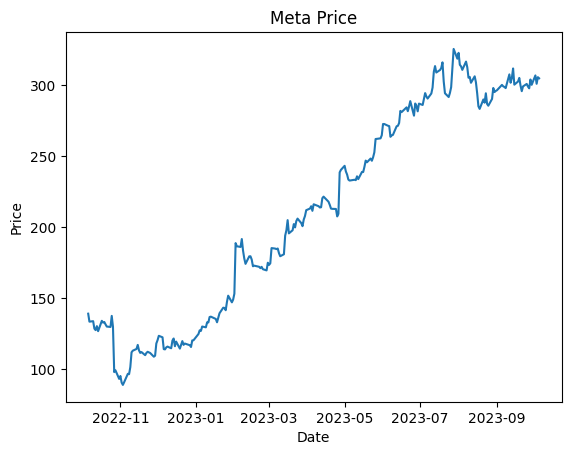

In [25]:
plt.plot(meta['Date'], meta['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Meta Price')
plt.show()

In [ ]:
# psar using inbuilt function TA-Lib (library for technical indicators)
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib
meta['SAR'] = talib.SAR(meta['High'], meta['Low'], acceleration = 0.02, maximum = 0.2)

--2023-10-06 12:43:03--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-10-06 12:43:03--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-10-06 12:43:03--  http://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving newco

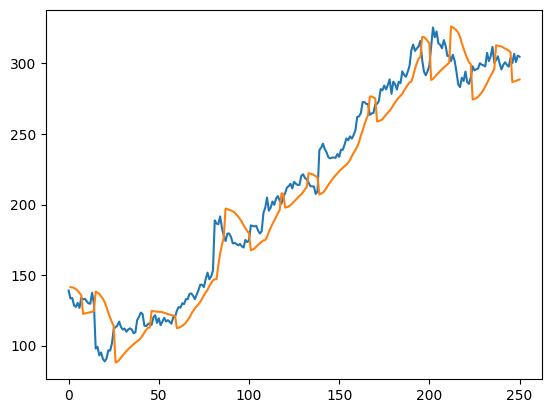

In [27]:
plt.plot(meta[['Adj Close', 'SAR']][:500])
plt.show()

In [30]:
def psar(barsdata, af_i = 0.02, af_max = 0.2):
    length = len(barsdata)
    dates = list(barsdata.index)
    high = list(barsdata['High'])
    low = list(barsdata['Low'])
    close = list(barsdata['Adj Close'])
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = af_i
    ep = low[0]
    hp = high[0]
    lp = low[0]

    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])

        reverse = False

        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = af_i
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = af_i

        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + af_i, af_max)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + af_i, af_max)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]

        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]

    return {"dates":dates, "high":high, "low":low, "Adj Close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}


In [32]:
startidx = 0
endidx = len(meta)
result = psar(meta)
dates = result['dates'][startidx:endidx]
close = result['Adj Close'][startidx:endidx]
psarbear = result['psarbear'][startidx:endidx]
psarbull = result['psarbull'][startidx:endidx]

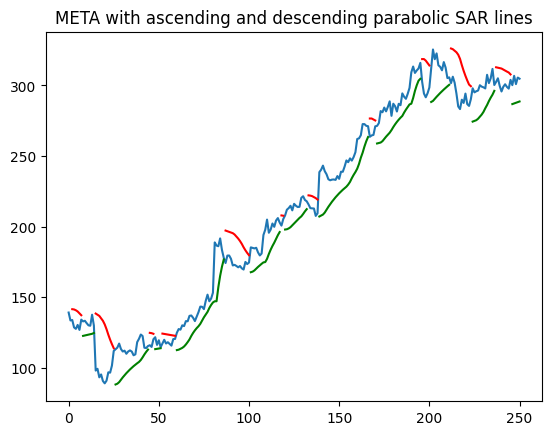

In [33]:
plt.plot(dates, close)
plt.plot(dates, psarbull, color = 'green')
plt.plot(dates, psarbear, color = 'red')

plt.title("META with ascending and descending parabolic SAR lines")
plt.show()